# Imports

In [ ]:
!pip install -q sklearn2pmml dask[dataframe]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 43.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    mean_absolute_percentage_error, mean_poisson_deviance
)
# from sklearn2pmml.statsmodels import StatsModelsRegressor
from sklearn2pmml import sklearn2pmml
import joblib

# Load the Data

In [ ]:
# Download the CSV file from GitHub
!wget -O nyc_bb_bicyclist_counts.csv https://gist.githubusercontent.com/sachinsdate/c17931a3f000492c1c42cf78bf4ce9fe/raw/7a5131d3f02575668b3c7e8c146b6a285acd2cd7/nyc_bb_bicyclist_counts.csv

# Load the CSV file into a DataFrame
df = pd.read_csv('nyc_bb_bicyclist_counts.csv', header=0, parse_dates=[0], index_col=[0])

# Make a copy for later
df_copy = df.copy()

# Display the first few rows of the DataFrame
display(df.head())

--2024-08-14 01:01:18--  https://gist.githubusercontent.com/sachinsdate/c17931a3f000492c1c42cf78bf4ce9fe/raw/7a5131d3f02575668b3c7e8c146b6a285acd2cd7/nyc_bb_bicyclist_counts.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6804 (6.6K) [text/plain]
Saving to: ‘nyc_bb_bicyclist_counts.csv’

nyc_bb_bicyclist_co 100%[===================>]   6.64K  --.-KB/s    in 0s      

2024-08-14 01:01:18 (85.0 MB/s) - ‘nyc_bb_bicyclist_counts.csv’ saved [6804/6804]



<ipython-input-9-2aa7dd8b0b05>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('nyc_bb_bicyclist_counts.csv', header=0, parse_dates=[0], index_col=[0])


,HIGH_T,LOW_T,PRECIP,BB_COUNT
Date,,,,
2017-04-01,46.0,37.0,0.00,606
2017-04-02,62.1,41.0,0.00,2021
2017-04-03,63.0,50.0,0.03,2470
2017-04-04,51.1,46.0,1.18,723
2017-04-05,63.0,46.0,0.00,2807


In [ ]:
# Add derived variables
ds = df.index.to_series()
df['MONTH'] = ds.dt.month
df['DAY_OF_WEEK'] = ds.dt.dayofweek
df['DAY'] = ds.dt.day

# Display the first few rows of the DataFrame
display(df.head())

,HIGH_T,LOW_T,PRECIP,BB_COUNT,MONTH,DAY_OF_WEEK,DAY
Date,,,,,,,
2017-04-01,46.0,37.0,0.00,606,4,5,1
2017-04-02,62.1,41.0,0.00,2021,4,6,2
2017-04-03,63.0,50.0,0.03,2470,4,0,3
2017-04-04,51.1,46.0,1.18,723,4,1,4
2017-04-05,63.0,46.0,0.00,2807,4,2,5


In [ ]:
# First date to last date
print(f'First date: {df.index.min()}')
print(f'Last date: {df.index.max()}')

First date: 2017-04-01 00:00:00
Last date: 2017-10-31 00:00:00


# Split the Data

In [ ]:
# Set training set size
train_size = int(len(df) * 0.8)

# Create training and testing datasets
df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

print(f'Training set length: {len(df_train)}')
print(f'Testing set length: {len(df_test)}')

Training set length: 171
Testing set length: 43


In [ ]:
# Setup the regression expression in patsy notation
expr = """BB_COUNT ~ DAY + DAY_OF_WEEK + MONTH + HIGH_T + LOW_T + PRECIP - 1"""  # -1 to exclude the intercept

# Set up the X and y matrices for the training and testing datasets
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

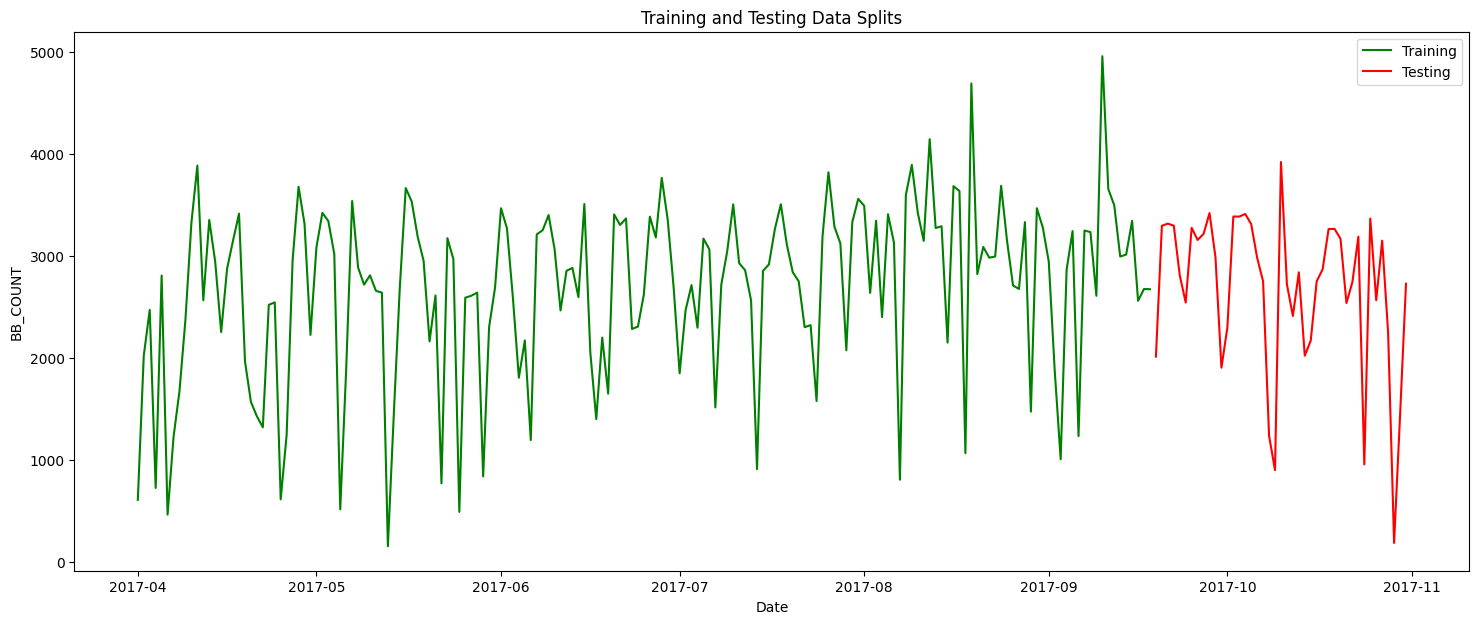

In [ ]:
# Plot the data splits
plt.figure(figsize=(18, 7))
plt.plot(df_train.index, df_train['BB_COUNT'], label='Training', color='green')
plt.plot(df_test.index, df_test['BB_COUNT'], label='Testing', color='red')
plt.xlabel('Date')
plt.ylabel('BB_COUNT')
plt.title('Training and Testing Data Splits')
plt.legend()
plt.show()

In [ ]:
# Print shapes
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'\nX_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

# First date and last date
print(f'\nFirst date (training): {X_train.index.min()}')
print(f'Last date (training): {X_train.index.max()}')
print(f'\nFirst date (testing): {X_test.index.min()}')
print(f'Last date (testing): {X_test.index.max()}')

X_train shape: (171, 6)
y_train shape: (171, 1)

X_test shape: (43, 6)
y_test shape: (43, 1)

First date (training): 2017-04-01 00:00:00
Last date (training): 2017-09-18 00:00:00

First date (testing): 2017-09-19 00:00:00
Last date (testing): 2017-10-31 00:00:00


In [ ]:
# Display the first few rows of the X and y matrices
print('X_train:')
display(X_train.head())
print('\ny_train:')
display(y_train.head())
print('\nX_test:')
display(X_test.head())
print('\ny_test:')
display(y_test.head())

X_train:


,DAY,DAY_OF_WEEK,MONTH,HIGH_T,LOW_T,PRECIP
Date,,,,,,
2017-04-01,1.0,5.0,4.0,46.0,37.0,0.00
2017-04-02,2.0,6.0,4.0,62.1,41.0,0.00
2017-04-03,3.0,0.0,4.0,63.0,50.0,0.03
2017-04-04,4.0,1.0,4.0,51.1,46.0,1.18
2017-04-05,5.0,2.0,4.0,63.0,46.0,0.00



y_train:


,BB_COUNT
Date,
2017-04-01,606.0
2017-04-02,2021.0
2017-04-03,2470.0
2017-04-04,723.0
2017-04-05,2807.0



X_test:


,DAY,DAY_OF_WEEK,MONTH,HIGH_T,LOW_T,PRECIP
Date,,,,,,
2017-09-19,19.0,1.0,9.0,78.1,69.1,0.22
2017-09-20,20.0,2.0,9.0,78.1,71.1,0.00
2017-09-21,21.0,3.0,9.0,80.1,71.1,0.00
2017-09-22,22.0,4.0,9.0,82.0,66.0,0.00
2017-09-23,23.0,5.0,9.0,86.0,68.0,0.00



y_test:


,BB_COUNT
Date,
2017-09-19,2012.0
2017-09-20,3296.0
2017-09-21,3317.0
2017-09-22,3297.0
2017-09-23,2810.0


# Model & Tuning

In [ ]:
# Modified statsmodels.py script (sklearn2pmml library)
# Support for Negative Binomial regression and alpha dispersion parameter
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn2pmml import _is_ordinal
from statsmodels.base.model import Model
from statsmodels.tools import add_constant
import statsmodels.api as sm
import numpy as np


class StatsModelsEstimator(BaseEstimator):
    """
    Base class for integrating StatsModels estimators with scikit-learn.

    Parameters
    ----------
    model_class : class
        A StatsModels model class. This should be a subclass of `statsmodels.base.model.Model`.
    fit_intercept : bool, default=True
        Whether to calculate the intercept for the model. If set to False, no intercept will be used in calculations.
    alpha : float, default=1.0
        Dispersion parameter for the Negative Binomial model. Controls the variance structure of the distribution.
    **init_params : dict, optional
        Additional keyword arguments to pass to the StatsModels model class during initialization.
    """

    def __init__(self, model_class, fit_intercept=True, alpha=1.0, **init_params):
        if not isinstance(model_class, type):
            raise TypeError("The model class object is not a Python class")
        if not issubclass(model_class, Model):
            raise TypeError("The model class is not a subclass of {}".format(Model.__name__))
        self.model_class = model_class
        self.fit_intercept = fit_intercept
        self.alpha = alpha  # Dispersion parameter for Negative Binomial
        self.init_params = init_params

    def fit(self, X, y, **fit_params):
        """
        Fit the StatsModels model.

        Parameters
        ----------
        X : array-like or pandas DataFrame, shape (n_samples, n_features)
            Training data.
        y : array-like or pandas Series, shape (n_samples,)
            Target values.
        **fit_params : dict, optional
            Additional fit parameters to pass to the `fit` method of the StatsModels model.

        Returns
        -------
        self : object
            Returns self.
        """
        if self.fit_intercept:
            X = add_constant(X, has_constant="add")

        # Create the family instance with the specified alpha
        family_instance = sm.families.NegativeBinomial(alpha=self.alpha)

        # Pass the parameters to the statsmodels model during initialization
        self.model_ = self.model_class(
            endog=y,
            exog=X,
            family=family_instance,
            **self.init_params
        )

        self.results_ = self.model_.fit(**fit_params)
        return self

    def remove_data(self):
        """
        Removes data from the fitted model to reduce memory usage.

        This is particularly useful when storing the model for later use,
        but the original data is no longer needed.
        """
        self.results_.remove_data()

class StatsModelsRegressor(StatsModelsEstimator, RegressorMixin):
    """
    A scikit-learn-compatible regressor using StatsModels.

    This class wraps StatsModels regression models, making them compatible
    with the scikit-learn API.

    Parameters
    ----------
    model_class : class
        A StatsModels model class. This should be a subclass of `statsmodels.base.model.Model`.
    fit_intercept : bool, default=True
        Whether to calculate the intercept for the model. If set to False, no intercept will be used in calculations.
    alpha : float, default=1.0
        Dispersion parameter for the Negative Binomial model. Controls the variance structure of the distribution.
    **init_params : dict, optional
        Additional keyword arguments to pass to the StatsModels model class during initialization.
    """

    def __init__(self, model_class, fit_intercept=True, alpha=1.0, **init_params):
        super(StatsModelsRegressor, self).__init__(model_class=model_class,
                                                   fit_intercept=fit_intercept,
                                                   alpha=alpha,
                                                   **init_params)

    def regression_table_(self):
        """
        Returns the regression table (coefficients and other statistics).

        Returns
        -------
        pandas Series
            The fitted parameters from the model.
        """
        return self.results_.params.T

    @property
    def coef_(self):
        """
        Returns the coefficients of the fitted model.

        Returns
        -------
        numpy array
            The coefficients of the model. If `fit_intercept` is True, the intercept is excluded.
        """
        reg_table = self.regression_table_()
        if self.fit_intercept:
            reg_table = reg_table[1:]
        return reg_table

    @property
    def intercept_(self):
        """
        Returns the intercept of the fitted model.

        Returns
        -------
        float
            The intercept of the model. If `fit_intercept` is False, returns 0.0.
        """
        reg_table = self.regression_table_()
        if self.fit_intercept:
            return reg_table[0]
        return 0.0

    def predict(self, X, **predict_params):
        """
        Predict using the fitted StatsModels model.

        Parameters
        ----------
        X : array-like or pandas DataFrame, shape (n_samples, n_features)
            Samples.
        **predict_params : dict, optional
            Additional parameters to pass to the `predict` method of the StatsModels model.

        Returns
        -------
        numpy array
            Predicted values.
        """
        if self.fit_intercept:
            X = add_constant(X, has_constant="add")
        return self.results_.predict(exog=X, **predict_params)

In [ ]:
# Wrapper for hyperparameter tuning
class TunableStatsModelsRegressor(StatsModelsRegressor):
    """
    A scikit-learn-compatible regressor with hyperparameter tuning support using StatsModels.

    This class extends the StatsModelsRegressor by adding functionality for hyperparameter tuning.
    It allows the user to specify a set of parameters that can be tuned during model fitting.

    Parameters
    ----------
    model_class : class
        A StatsModels model class. This should be a subclass of `statsmodels.base.model.Model`.
    fit_intercept : bool, default=True
        Whether to calculate the intercept for the model. If set to False, no intercept will be used in calculations.
    alpha : float, default=1.0
        Dispersion parameter for the Negative Binomial model. Controls the variance structure of the distribution.
    tune_params : dict, optional
        Dictionary of parameters to be tuned during the fitting process.
    **init_params : dict, optional
        Additional keyword arguments to pass to the StatsModels model class during initialization.

    Attributes
    ----------
    tune_params : dict
        Parameters used for tuning during model fitting.
    """

    def __init__(self, model_class, fit_intercept=True, alpha=1.0, tune_params={}, **init_params):
        super(TunableStatsModelsRegressor, self).__init__(model_class=model_class,
                                                          fit_intercept=fit_intercept,
                                                          alpha=alpha,
                                                          **init_params)
        self.tune_params = tune_params
        self.alpha = alpha

    def set_params(self, **params):
        """
        Set the parameters of the model, including the ones used for tuning.

        Parameters
        ----------
        **params : dict
            Dictionary of parameters to set. This includes model-specific parameters such as `model_class`,
            `fit_intercept`, `alpha`, `tune_params`, and any other parameters intended for tuning.

        Returns
        -------
        self : object
            Returns self.
        """
        super_params = dict([(k, params.pop(k)) for k, v in dict(**params).items()
                             if k in ["model_class", "fit_intercept", "alpha", "tune_params"]])
        super(TunableStatsModelsRegressor, self).set_params(**super_params)
        setattr(self, "tune_params", dict(**params))

    def fit(self, X, y, **fit_params):
        """
        Fit the model using the specified parameters and any additional tuning parameters.

        Parameters
        ----------
        X : array-like or pandas DataFrame, shape (n_samples, n_features)
            Training data.
        y : array-like or pandas Series, shape (n_samples,)
            Target values.
        **fit_params : dict, optional
            Additional parameters to pass to the `fit` method of the StatsModels model.

        Returns
        -------
        self : object
            Returns self.
        """
        tune_params = self.tune_params.copy()
        tune_params.update(fit_params)
        super(TunableStatsModelsRegressor, self).fit(X, y, **tune_params)
        return self

In [ ]:
# Consolidation of the modified StatsModelsRegressor and the tunable wrapper class
from sklearn.base import BaseEstimator, RegressorMixin
from statsmodels.base.model import Model
from statsmodels.tools import add_constant
import statsmodels.api as sm


class TunableStatsModelsNBRegressor(BaseEstimator, RegressorMixin):
    """
    A scikit-learn-compatible Negative Binomial regressor with hyperparameter tuning support using StatsModels.

    This class consolidates functionality for fitting a Negative Binomial regression model and
    supports hyperparameter tuning. It integrates StatsModels' capabilities with the scikit-learn API.

    Parameters
    ----------
    model_class : class
        A StatsModels model class. This should be a subclass of `statsmodels.base.model.Model`.
    fit_intercept : bool, default=True
        Whether to calculate the intercept for the model. If set to False, no intercept will be used in calculations.
    alpha : float, default=1.0
        Dispersion parameter for the Negative Binomial model. Controls the variance structure of the distribution.
    tune_params : dict, optional
        Dictionary of parameters to be tuned during the fitting process.
    **init_params : dict, optional
        Additional keyword arguments to pass to the StatsModels model class during initialization.

    Attributes
    ----------
    model_class : class
        The StatsModels model class used for fitting.
    fit_intercept : bool
        Whether to fit an intercept in the model.
    alpha : float
        Dispersion parameter for the Negative Binomial model.
    init_params : dict
        Initial parameters for the StatsModels model.
    tune_params : dict
        Parameters used for tuning during model fitting.
    model_ : statsmodels.base.model.Model
        The instantiated StatsModels model.
    results_ : statsmodels.base.model.Results
        The results of the fitted model.
    """

    def __init__(self, model_class, fit_intercept=True, alpha=1.0, tune_params={}, **init_params):
        if not isinstance(model_class, type):
            raise TypeError("The model class object is not a Python class")
        if not issubclass(model_class, Model):
            raise TypeError("The model class is not a subclass of {}".format(Model.__name__))
        self.model_class = model_class
        self.fit_intercept = fit_intercept
        self.alpha = alpha  # Dispersion parameter for Negative Binomial
        self.init_params = init_params
        self.tune_params = tune_params

    def fit(self, X, y, **fit_params):
        """
        Fit the Negative Binomial model using the specified parameters and any additional tuning parameters.

        Parameters
        ----------
        X : array-like or pandas DataFrame, shape (n_samples, n_features)
            Training data.
        y : array-like or pandas Series, shape (n_samples,)
            Target values.
        **fit_params : dict, optional
            Additional parameters to pass to the `fit` method of the StatsModels model.

        Returns
        -------
        self : object
            Returns self.
        """
        if self.fit_intercept:
            X = add_constant(X, has_constant="add")

        # Create the family instance with the specified alpha
        family_instance = sm.families.NegativeBinomial(alpha=self.alpha)

        # Initialize the statsmodels model with given parameters
        self.model_ = self.model_class(
            endog=y,
            exog=X,
            family=family_instance,
            **self.init_params
        )

        tune_params = self.tune_params.copy()
        tune_params.update(fit_params)

        # Fit the model with tuning parameters
        self.results_ = self.model_.fit(**tune_params)
        return self

    def set_params(self, **params):
        """
        Set the parameters of the model, including the ones used for tuning.

        Parameters
        ----------
        **params : dict
            Dictionary of parameters to set. This includes model-specific parameters such as `model_class`,
            `fit_intercept`, `alpha`, `tune_params`, and any other parameters intended for tuning.

        Returns
        -------
        self : object
            Returns self.
        """
        super_params = {k: params.pop(k) for k in list(params.keys()) if k in ["model_class", "fit_intercept", "alpha", "tune_params"]}
        for param, value in super_params.items():
            setattr(self, param, value)
        self.tune_params.update(params)
        return self

    def predict(self, X, **predict_params):
        """
        Predict using the fitted Negative Binomial model.

        Parameters
        ----------
        X : array-like or pandas DataFrame, shape (n_samples, n_features)
            Samples.
        **predict_params : dict, optional
            Additional parameters to pass to the `predict` method of the StatsModels model.

        Returns
        -------
        numpy array
            Predicted values.
        """
        if self.fit_intercept:
            X = add_constant(X, has_constant="add")
        return self.results_.predict(exog=X, **predict_params)

    def remove_data(self):
        """
        Removes data from the fitted model to reduce memory usage.

        This is particularly useful when storing the model for later use,
        but the original data is no longer needed.
        """
        if hasattr(self.results_, 'remove_data'):
            self.results_.remove_data()

    def regression_table_(self):
        """
        Returns the regression table (coefficients and other statistics).

        Returns
        -------
        pandas Series
            The fitted parameters from the model.
        """
        return self.results_.params.T

    @property
    def coef_(self):
        """
        Returns the coefficients of the fitted model.

        Returns
        -------
        numpy array
            The coefficients of the model. If `fit_intercept` is True, the intercept is excluded.
        """
        reg_table = self.regression_table_()
        if self.fit_intercept:
            reg_table = reg_table[1:]
        return reg_table

    @property
    def intercept_(self):
        """
        Returns the intercept of the fitted model.

        Returns
        -------
        float
            The intercept of the model. If `fit_intercept` is False, returns 0.0.
        """
        reg_table = self.regression_table_()
        if self.fit_intercept:
            return reg_table[0]
        return 0.0

In [ ]:
# Define the regressor with GLM for Negative Binomial regression
nb_regressor = TunableStatsModelsNBRegressor(sm.GLM, family=sm.families.NegativeBinomial(alpha=1.0))

# Create a pipeline
nb_pipeline = Pipeline([
    ("regressor", nb_regressor)
])

In [ ]:
import inspect

# Get the signature of the method
signature = inspect.signature(sm.GLM.fit)

# Print the signature
print("Signature Results:")
print(signature)

# Print all parameters and their default values
for name, param in signature.parameters.items():
    print(f"{name}: {param.default}")

# Use help method
print("\nHelp Results:")
help(sm.GLM.fit)

Signature Results:
(self, start_params=None, maxiter=100, method='IRLS', tol=1e-08, scale=None, cov_type='nonrobust', cov_kwds=None, use_t=None, full_output=True, disp=False, max_start_irls=3, **kwargs)
self: <class 'inspect._empty'>
start_params: None
maxiter: 100
method: IRLS
tol: 1e-08
scale: None
cov_type: nonrobust
cov_kwds: None
use_t: None
full_output: True
disp: False
max_start_irls: 3
kwargs: <class 'inspect._empty'>

Help Results:
Help on function fit in module statsmodels.genmod.generalized_linear_model:

fit(self, start_params=None, maxiter=100, method='IRLS', tol=1e-08, scale=None, cov_type='nonrobust', cov_kwds=None, use_t=None, full_output=True, disp=False, max_start_irls=3, **kwargs)
    Fits a generalized linear model for a given family.
    
    Parameters
    ----------
    start_params : array_like, optional
        Initial guess of the solution for the loglikelihood maximization.
        The default is family-specific and is given by the
        ``family.starting_m

In [ ]:
# Define parameter grid for hyperparameter tuning
param_grid = {
    "regressor__fit_intercept": [True, False],
    "regressor__alpha": [0.5, 1.0, 2.0],
    "regressor__maxiter": [50, 100, 200],
    "regressor__tol": [1e-4, 1e-6, 1e-8],
    "regressor__cov_type": ['nonrobust', 'HC1', 'HC3'],
    "regressor__wls_method": ['lstsq', 'pinv', 'qr'],
    "regressor__optim_hessian": ['eim', 'oim']
}

In [ ]:
from sklearn.metrics import get_scorer_names

# Print all scorer callables
all_scorers = get_scorer_names()
for scorer in all_scorers:
    print(scorer)

accuracy
adjusted_mutual_info_score
adjusted_rand_score
average_precision
balanced_accuracy
completeness_score
d2_absolute_error_score
explained_variance
f1
f1_macro
f1_micro
f1_samples
f1_weighted
fowlkes_mallows_score
homogeneity_score
jaccard
jaccard_macro
jaccard_micro
jaccard_samples
jaccard_weighted
matthews_corrcoef
max_error
mutual_info_score
neg_brier_score
neg_log_loss
neg_mean_absolute_error
neg_mean_absolute_percentage_error
neg_mean_gamma_deviance
neg_mean_poisson_deviance
neg_mean_squared_error
neg_mean_squared_log_error
neg_median_absolute_error
neg_negative_likelihood_ratio
neg_root_mean_squared_error
neg_root_mean_squared_log_error
normalized_mutual_info_score
positive_likelihood_ratio
precision
precision_macro
precision_micro
precision_samples
precision_weighted
r2
rand_score
recall
recall_macro
recall_micro
recall_samples
recall_weighted
roc_auc
roc_auc_ovo
roc_auc_ovo_weighted
roc_auc_ovr
roc_auc_ovr_weighted
top_k_accuracy
v_measure_score


In [ ]:
# Define scoring dictionary
scoring = {
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'neg_mean_absolute_percentage_error': 'neg_mean_absolute_percentage_error',
    'neg_mean_poisson_deviance': 'neg_mean_poisson_deviance'
}

In [ ]:
# Initialize the CV object
cv = TimeSeriesSplit(n_splits=5)

In [ ]:
# Initialize GridSearchCV
tuner = GridSearchCV(
    nb_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    refit='neg_mean_squared_error',
    return_train_score=True,
    verbose=1
)

# Fit the model
tuner.fit(X_train, y_train)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('regressor',
                                        TunableStatsModelsNBRegressor(model_class=<class 'statsmodels.genmod.generalized_linear_model.GLM'>))]),
             param_grid={'regressor__alpha': [0.5, 1.0, 2.0],
                         'regressor__cov_type': ['nonrobust', 'HC1', 'HC3'],
                         'regressor__fit_intercept': [Tr...
             refit='neg_mean_squared_error', return_train_score=True,
             scoring={'neg_mean_absolute_error': 'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error': 'neg_mean_absolute_percentage_error',
                      'neg_mean_poisson_deviance': 'neg_mean_poisson_deviance',
                      'neg_mean_squared_error': 'neg_mean_squared_error',
                      'neg_root_mean_squared_error': 'neg_root_mean_squared_error'},
             verbose=1)

In [ ]:
# Print CV results
cv_results = pd.DataFrame(tuner.cv_results_)

# # Display all rows and columns
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# # Reset the display settings
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')

# Sort by average test MSE
cv_results = cv_results.sort_values(by='mean_test_neg_mean_squared_error', ascending=False)

# Move test MSE column to first column
mse_column = cv_results.pop('mean_test_neg_mean_squared_error')
cv_results.insert(0, 'MSE', mse_column)

# Display the DataFrame
display(cv_results.head(10))

,MSE,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__alpha,param_regressor__cov_type,param_regressor__fit_intercept,param_regressor__maxiter,param_regressor__optim_hessian,...,mean_test_neg_mean_poisson_deviance,std_test_neg_mean_poisson_deviance,rank_test_neg_mean_poisson_deviance,split0_train_neg_mean_poisson_deviance,split1_train_neg_mean_poisson_deviance,split2_train_neg_mean_poisson_deviance,split3_train_neg_mean_poisson_deviance,split4_train_neg_mean_poisson_deviance,mean_train_neg_mean_poisson_deviance,std_train_neg_mean_poisson_deviance
240,-674697.13681,0.009549,0.000840,0.013068,0.001204,0.5,HC3,True,100,eim,...,-250.860503,109.540031,1,-64.042951,-169.869192,-160.729977,-143.778106,-147.132398,-137.110525,37.722073
123,-674697.13681,0.008714,0.001521,0.012141,0.001613,0.5,HC1,True,50,oim,...,-250.860503,109.540031,1,-64.042951,-169.869192,-160.729977,-143.778106,-147.132398,-137.110525,37.722073
267,-674697.13681,0.008782,0.001198,0.012819,0.002795,0.5,HC3,True,200,oim,...,-250.860503,109.540031,1,-64.042951,-169.869192,-160.729977,-143.778106,-147.132398,-137.110525,37.722073
42,-674697.13681,0.007445,0.001125,0.009224,0.001540,0.5,nonrobust,True,200,eim,...,-250.860503,109.540031,1,-64.042951,-169.869192,-160.729977,-143.778106,-147.132398,-137.110525,37.722073
51,-674697.13681,0.007157,0.000708,0.008548,0.000483,0.5,nonrobust,True,200,oim,...,-250.860503,109.540031,1,-64.042951,-169.869192,-160.729977,-143.778106,-147.132398,-137.110525,37.722073
24,-674697.13681,0.007800,0.002260,0.010549,0.003234,0.5,nonrobust,True,100,eim,...,-250.860503,109.540031,1,-64.042951,-169.869192,-160.729977,-143.778106,-147.132398,-137.110525,37.722073
258,-674697.13681,0.008936,0.000532,0.009820,0.001163,0.5,HC3,True,200,eim,...,-250.860503,109.540031,1,-64.042951,-169.869192,-160.729977,-143.778106,-147.132398,-137.110525,37.722073
249,-674697.13681,0.009959,0.001623,0.013729,0.003318,0.5,HC3,True,100,oim,...,-250.860503,109.540031,1,-64.042951,-169.869192,-160.729977,-143.778106,-147.132398,-137.110525,37.722073
231,-674697.13681,0.012840,0.005479,0.012119,0.001549,0.5,HC3,True,50,oim,...,-250.860503,109.540031,1,-64.042951,-169.869192,-160.729977,-143.778106,-147.132398,-137.110525,37.722073
222,-674697.13681,0.008186,0.000743,0.011722,0.000866,0.5,HC3,True,50,eim,...,-250.860503,109.540031,1,-64.042951,-169.869192,-160.729977,-143.778106,-147.132398,-137.110525,37.722073


In [ ]:
# Print the best estimator
print(f"Best Estimator: {tuner.best_estimator_}")

# Print the best parameters
print("\nBest Parameters:")
for param, value in tuner.best_params_.items():
    print(f"  {param}: {value}")

# Print the best score
print(f"\nBest score (MSE): {-tuner.best_score_:.3f}")

Best Estimator: Pipeline(steps=[('regressor',
                 TunableStatsModelsNBRegressor(alpha=0.5,
                                               model_class=<class 'statsmodels.genmod.generalized_linear_model.GLM'>,
                                               tune_params={'cov_type': 'nonrobust',
                                                            'maxiter': 50,
                                                            'optim_hessian': 'eim',
                                                            'tol': 1e-08,
                                                            'wls_method': 'lstsq'}))])

Best Parameters:
  regressor__alpha: 0.5
  regressor__cov_type: nonrobust
  regressor__fit_intercept: True
  regressor__maxiter: 50
  regressor__optim_hessian: eim
  regressor__tol: 1e-08
  regressor__wls_method: lstsq

Best score (MSE): 674697.137


In [ ]:
# Get the index of the best model
best_index = tuner.best_index_

# Get the scores of the best model
best_scores = {
    'MSE': -tuner.cv_results_['mean_test_neg_mean_squared_error'][best_index],
    'RMSE': -tuner.cv_results_['mean_test_neg_root_mean_squared_error'][best_index],
    'MAE': -tuner.cv_results_['mean_test_neg_mean_absolute_error'][best_index],
    'MAPE': -tuner.cv_results_['mean_test_neg_mean_absolute_percentage_error'][best_index],
    'MPD': -tuner.cv_results_['mean_test_neg_mean_poisson_deviance'][best_index]
}

# Create a DataFrame with rounded values
scores_df = pd.DataFrame({k: f"{v:.3f}" for k, v in best_scores.items()}, index=['Score']).T

# Set index name to "Metric"
scores_df.index.name = 'Metric'

# Display the DataFrame
print("Best estimator scores:")
display(scores_df)

Best estimator scores:


,Score
Metric,
MSE,674697.137
RMSE,803.314
MAE,633.410
MAPE,0.271
MPD,250.861


In [ ]:
# Save the best model
best_pipeline = tuner.best_estimator_
joblib.dump(best_pipeline, "BestNegativeBinomialModel.pkl")

# Load the best model
loaded_pipeline = joblib.load("BestNegativeBinomialModel.pkl")

In [ ]:
# Model summary
regressor = loaded_pipeline.named_steps['regressor']
print("MODEL SUMMARY 1:")
print(regressor.results_.summary())
print("\nMODEL SUMMARY 2:")
print(regressor.results_.summary2())

MODEL SUMMARY 1:
                 Generalized Linear Model Regression Results                  
Dep. Variable:               BB_COUNT   No. Observations:                  171
Model:                            GLM   Df Residuals:                      164
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1453.4
Date:                Wed, 14 Aug 2024   Deviance:                       26.814
Time:                        01:04:52   Pearson chi2:                     23.6
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1724
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.6423      0.409

In [ ]:
# Get StatsModels GLM metrics
cs_r2 = regressor.results_.pseudo_rsquared(kind='cs')
mcf_r2 = regressor.results_.pseudo_rsquared(kind='mcf')
aic = regressor.results_.aic
bic = regressor.results_.bic_llf
dev = regressor.results_.deviance
llik = regressor.results_.llf
llnull = regressor.results_.llnull
mu = regressor.results_.mu
pchi2 = regressor.results_.pearson_chi2

# Create metrics DataFrame
metrics = pd.DataFrame({
    'Metric': [
        'MCF_R2',
        'CS_R2',
        'AIC',
        'BIC',
        'DEV',
        'LL',
        'LL_0',
        'PCHI2'
    ],
    'Score': [
        mcf_r2,
        cs_r2,
        aic,
        bic,
        dev,
        llik,
        llnull,
        pchi2
    ]
}).round(3)

# Set index to 'Metric'
metrics.set_index('Metric', inplace=True)

# Display the DataFrame
display(metrics)

,Score
Metric,
MCF_R2,0.011
CS_R2,0.172
AIC,2920.747
BIC,2942.738
DEV,26.814
LL,-1453.373
LL_0,-1469.548
PCHI2,23.602


# Predictions

In [ ]:
# Add the intercept column if necessary
if 'Intercept' not in X_test.columns:
    X_test['Intercept'] = 1

In [ ]:
# Make predictions using the trained Negative Binomial model
nb_predictions = regressor.results_.get_prediction(X_test)

# Print out the predictions
predictions_summary_frame = nb_predictions.summary_frame()
display(predictions_summary_frame)

,mean,mean_se,mean_ci_lower,mean_ci_upper
Date,,,,
2017-09-19,1.624232e+56,1.290088e+57,2.816847e+49,9.365547e+62
2017-09-20,1.331008e+59,1.105872e+60,1.127052e+52,1.571872e+66
2017-09-21,1.069529e+62,9.316057e+62,4.119640e+54,2.776679e+69
2017-09-22,7.318079e+64,6.679432e+65,1.245156e+57,4.301011e+72
2017-09-23,6.555213e+67,6.261747e+68,4.848863e+59,8.862039e+75
2017-09-24,5.709996e+70,5.698667e+71,1.826037e+62,1.785510e+79
2017-09-25,4.472373e+73,4.611887e+74,7.464385e+64,2.679675e+82
2017-09-26,2.784358e+76,2.963101e+77,2.433757e+67,3.185465e+85
2017-09-27,2.431115e+79,2.687169e+80,9.490152e+69,6.227846e+88


In [ ]:
# Drop the Intercept term
X_test = X_test.drop('Intercept', axis=1)

In [ ]:
# Make predictions using the trained Negative Binomial model
predicted_counts = regressor.predict(X_test)
predicted_counts = pd.DataFrame(predicted_counts, index=X_test.index, columns=['BB_COUNT'])

# Print out the predictions
print("First few predictions:")
display(predicted_counts.head())
print("\nLast few predictions:")
display(predicted_counts.tail())

First few predictions:


,BB_COUNT
Date,
2017-09-19,2635.337616
2017-09-20,2860.857494
2017-09-21,3001.515146
2017-09-22,3444.837717
2017-09-23,3708.306181



Last few predictions:


,BB_COUNT
Date,
2017-10-27,2640.620541
2017-10-28,2708.217633
2017-10-29,355.570994
2017-10-30,2002.449107
2017-10-31,2307.924384


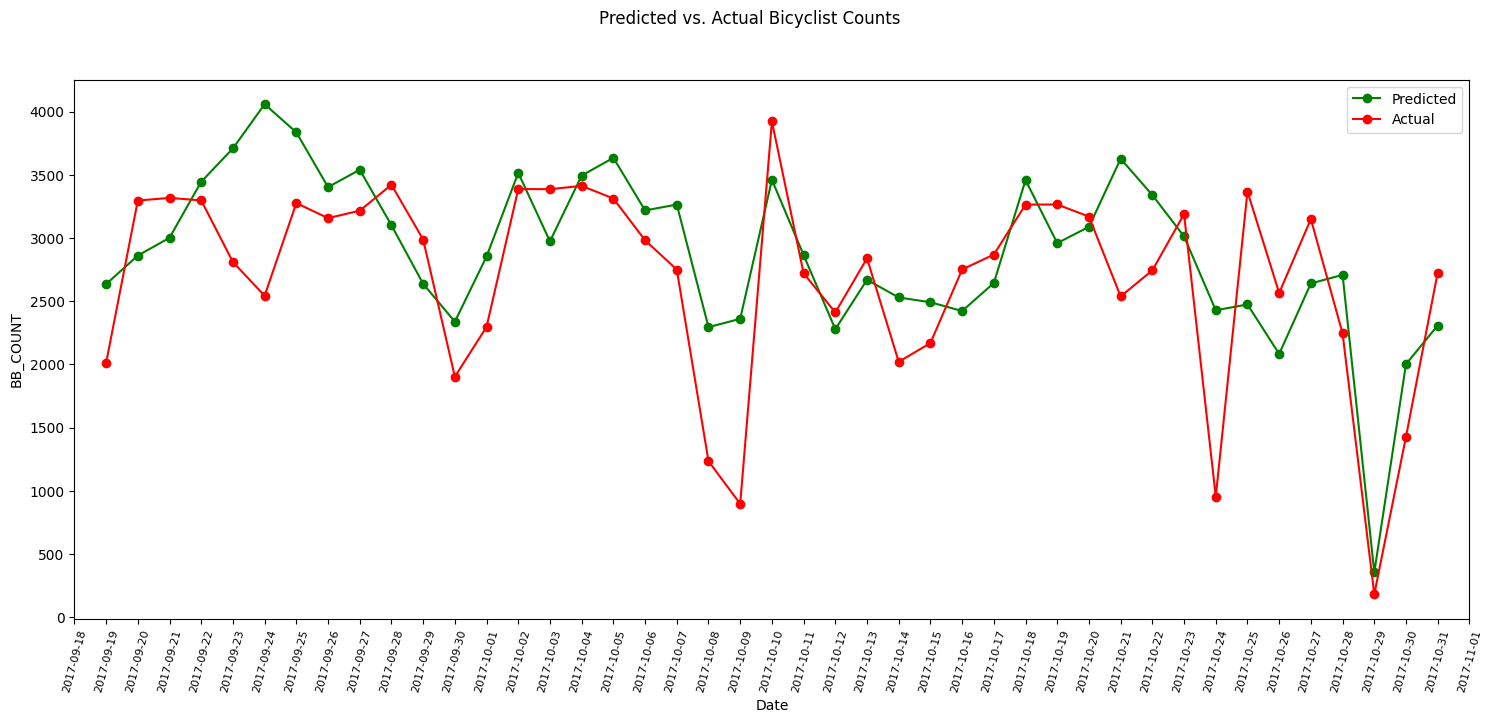

In [ ]:
import matplotlib.dates as mdates

# Plot the predicted counts versus the actual counts for the test data
actual_counts = y_test['BB_COUNT']
plt.figure(figsize=(18, 7))
plt.suptitle('Predicted vs. Actual Bicyclist Counts')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual')
plt.xlim([X_test.index.min() - pd.Timedelta(days=1), X_test.index.max() + pd.Timedelta(days=1)])
plt.xticks(rotation=75, fontsize=8)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Show every date
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.legend(handles=[predicted, actual])
plt.xlabel('Date')
plt.ylabel('BB_COUNT')
plt.show()

# Pipeline Selection

In [ ]:
!pip install -q pandas==2.1.4
!pip install -q torch==2.3.1+cu121 nvidia-cublas-cu12 nvidia-cuda-cupti-cu12 nvidia-cuda-nvrtc-cu12 nvidia-cuda-runtime-cu12 nvidia-cudnn-cu12 nvidia-cufft-cu12 nvidia-curand-cu12 nvidia-cusolver-cu12 nvidia-cusparse-cu12 nvidia-nvtx-cu12

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
feature-engine 1.8.0 requires pandas>=2.2.0, but you have pandas 2.1.4 which is incompatible.


In [ ]:
!pip uninstall -y cudf-cu12 google-colab

In [ ]:
!pip install -q scikit-lego[umap]
!pip install -q autoimpute feature-engine

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge, BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklego.preprocessing import IdentityTransformer
from sklego.decomposition.umap_reconstruction import UMAPOutlierDetection
from sklearn2pmml.ensemble import GBDTLMRegressor
from autoimpute.imputations import MiceImputer
from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ImportWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", message=".*os.fork.*", category=RuntimeWarning)

In [ ]:
# Display the original data (copied)
display(df_copy.head())

# Set training set size
train_size = int(len(df_copy) * 0.8)

# Create training and testing datasets
df_train_copy = df_copy.iloc[:train_size]
df_test_copy = df_copy.iloc[train_size:]

print(f"\nTraining set length: {len(df_train_copy)}")
print(f"Testing set length: {len(df_test_copy)}")

,HIGH_T,LOW_T,PRECIP,BB_COUNT
Date,,,,
2017-04-01,46.0,37.0,0.00,606
2017-04-02,62.1,41.0,0.00,2021
2017-04-03,63.0,50.0,0.03,2470
2017-04-04,51.1,46.0,1.18,723
2017-04-05,63.0,46.0,0.00,2807



Training set length: 171
Testing set length: 43


X_train shape: (171, 3)
y_train shape: (171, 1)

X_test shape: (43, 3)
y_test shape: (43, 1)



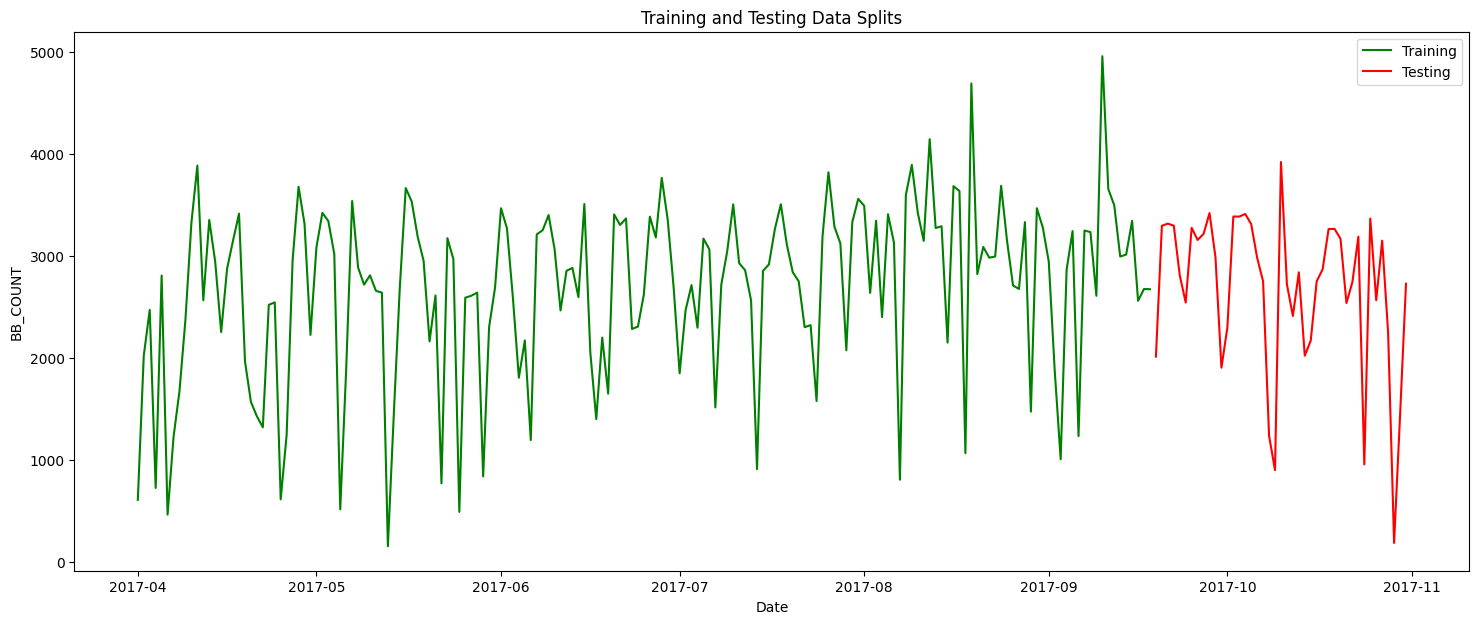

In [ ]:
# Setup the regression expression in patsy notation
expr = """BB_COUNT ~ HIGH_T + LOW_T + PRECIP - 1"""  # -1 to exclude the intercept

# Set up the X and y matrices for the training and testing datasets
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

# Print shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"\nX_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}\n")

# Plot the data splits
plt.figure(figsize=(18, 7))
plt.plot(df_train.index, df_train['BB_COUNT'], label='Training', color='green')
plt.plot(df_test.index, df_test['BB_COUNT'], label='Testing', color='red')
plt.xlabel('Date')
plt.ylabel('BB_COUNT')
plt.title('Training and Testing Data Splits')
plt.legend()
plt.show()

In [ ]:
# Outlier removal transformer that wraps around an outlier detection transformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted, check_array
import numpy as np
import pandas as pd


class OutlierRemover(BaseEstimator, TransformerMixin):
    """
    A transformer that wraps around an outlier detection estimator to remove or replace outliers.

    This transformer can be used to preprocess data by identifying outliers using a scikit-learn
    compatible outlier detection model. It can then either replace the detected outliers with NaN
    values or remove them entirely. The output format of the transformed data can be customized.

    Parameters
    ----------
    outlier_detector : scikit-learn compatible estimator
        An outlier detector that implements `.fit()` and `.predict()` methods.

    action : str, default='replace'
        Action to take on detected outliers.
        'replace' will replace outliers with NaN values.
        'remove' will remove the outliers entirely.

    output_type : str, default='same'
        Specifies the format of the output data.
        'same' will return the data in the same format as the input.
        'pandas' will return the data as a pandas DataFrame.
        'numpy' will return the data as a numpy array.
    """

    def __init__(self, outlier_detector, action='replace', output_type='same'):
        self.outlier_detector = outlier_detector
        self.action = action
        self.output_type = output_type

    def fit(self, X, y=None, **fit_params):
        """
        Fits the underlying outlier detector to the training data.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data.

        y : array-like of shape (n_samples,), default=None
            Target values.

        **fit_params : dict
            Additional parameters to pass to the outlier detector's fit method.

        Returns
        -------
        self : OutlierRemover
            The fitted transformer.
        """
        self.outlier_detector.fit(X, y, **fit_params)
        return self

    def transform(self, X, y=None):
        """
        Transforms the data by either replacing or removing outliers.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Input data to transform.

        y : array-like of shape (n_samples,), default=None
            Target values.

        Returns
        -------
        X_transformed : array-like
            The transformed data with outliers handled as specified.
        """
        check_is_fitted(self, 'outlier_detector')
        X_orig_type = type(X)

        # Store the original index and columns if applicable
        original_index = X.index if isinstance(X, (pd.DataFrame, pd.Series)) else None
        original_columns = X.columns if isinstance(X, pd.DataFrame) else None

        # Convert X to numpy array for internal processing
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X_values = X.values
        else:
            X_values = check_array(X, ensure_2d=True)

        # Predict outliers
        outliers = self.outlier_detector.predict(X_values) == -1

        if self.action == 'replace':
            # Replace outliers with NaN
            X_values[outliers] = np.nan
        elif self.action == 'remove':
            # Remove outliers
            X_values = X_values[~outliers]

        # Convert back to the desired output type
        if self.output_type == 'same':
            if X_orig_type == pd.DataFrame:
                X_transformed = pd.DataFrame(X_values, index=original_index, columns=original_columns)
            elif X_orig_type == pd.Series:
                X_transformed = pd.Series(X_values, index=original_index, name=X.name)
            else:
                X_transformed = X_values
        elif self.output_type == 'pandas':
            X_transformed = pd.DataFrame(X_values, index=original_index)
        elif self.output_type == 'numpy':
            X_transformed = np.array(X_values)
        else:
            raise ValueError("Invalid output_type specified. Choose 'same', 'pandas', or 'numpy'.")

        return X_transformed

    def fit_transform(self, X, y=None, **fit_params):
        """
        Fits the outlier detector and transforms the data in a single step.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Input data to fit and transform.

        y : array-like of shape (n_samples,), default=None
            Target values.

        **fit_params : dict
            Additional fitting parameters to pass to the outlier detector's fit method.

        Returns
        -------
        X_transformed : array-like
            The transformed data with outliers handled as specified.
        """
        return self.fit(X, y, **fit_params).transform(X, y)

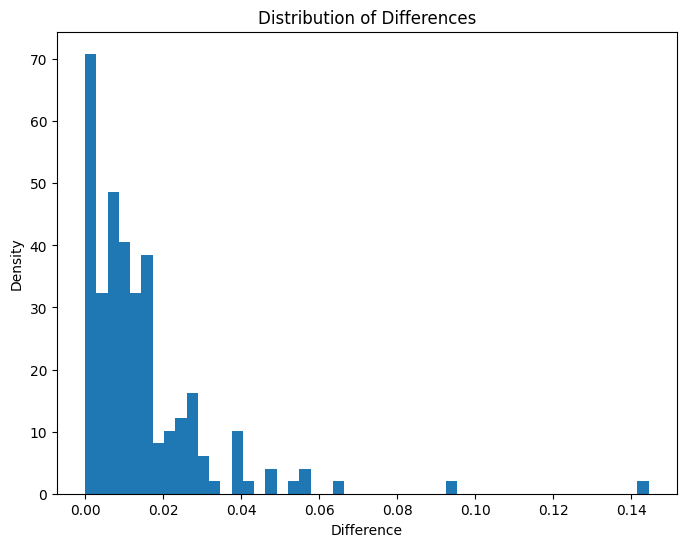

UMAPOutlierDetection(threshold=0.040927583432269946)

In [ ]:
# Fit UMAP outlier detector
umap_outlier_detector = UMAPOutlierDetection(n_components=2, threshold=0.5)
umap_outlier_detector.fit(X_train)
differences = umap_outlier_detector.difference(X_train)

# Visualize the distribution of differences
plt.figure(figsize=(8, 6))
plt.hist(differences, bins=50, density=True)
plt.xlabel("Difference")
plt.ylabel("Density")
plt.title("Distribution of Differences")
plt.show()

# Choose an appropriate threshold value based on the distribution analysis
chosen_threshold = np.percentile(differences, 95)

# Re-initialize the model with the chosen threshold and refit
umap_model = UMAPOutlierDetection(n_components=2, threshold=chosen_threshold)
umap_model.fit(X_train)

In [ ]:
# Transformer to handle MiceImputer output
import numpy as np
import pandas as pd
import random
from sklearn.base import BaseEstimator, TransformerMixin


class MiceImputerExtractor(BaseEstimator, TransformerMixin):
    """
    A transformer to extract a specific DataFrame from the list of tuples returned by MiceImputer.

    This transformer allows selection of a DataFrame from the output of the MiceImputer based on an
    index, or predefined options such as 'first', 'last', 'mean', or 'random'. The selected DataFrame
    is returned for further processing in a pipeline.

    Parameters
    ----------
    selection : int or str, default='first'
        The selection criterion for extracting a DataFrame.
        - If an integer is provided, it specifies the 1-based index of the DataFrame to select.
        - 'first': Selects the first DataFrame in the list.
        - 'last': Selects the last DataFrame in the list.
        - 'mean': Averages all the DataFrames in the list and returns the mean DataFrame.
        - 'random': Selects a random DataFrame from the list.

    Attributes
    ----------
    selection : int or str
        Stores the selection criterion.

    Examples
    --------
    >>> extractor = MiceImputerExtractor(selection='mean')
    >>> transformed_data = extractor.fit_transform(imputed_data)
    """

    def __init__(self, selection='first'):
        self.selection = selection

    def fit(self, X, y=None):
        """
        Fit method. This transformer does not learn anything, so it simply returns self.

        Parameters
        ----------
        X : list of tuples
            Input data to fit. Each tuple should consist of an integer and a DataFrame.

        y : array-like, default=None
            Target values (ignored).

        Returns
        -------
        self : object
            Returns self.
        """
        return self

    def transform(self, X):
        """
        Transform the input data by selecting the specified DataFrame from the list of tuples.

        Parameters
        ----------
        X : list of tuples
            The input data, where each element is a tuple consisting of an integer and a DataFrame.

        Returns
        -------
        df : pandas DataFrame
            The selected DataFrame based on the `selection` criterion.

        Raises
        ------
        TypeError
            If the input is not a list of tuples.
        ValueError
            If the selection integer is out of range or if an invalid selection option is provided.
        """
        if not isinstance(X, list) or not all(isinstance(item, tuple) for item in X):
            raise TypeError(f"Input must be a list of tuples. Got {type(X)} instead.")

        if isinstance(self.selection, int):
            # Handle integer-based selection (1-based index)
            if self.selection < 1 or self.selection > len(X):
                raise ValueError(f"Selection integer must be between 1 and {len(X)}")
            _, df = X[self.selection - 1]

        elif self.selection == 'first':
            _, df = X[0]
        elif self.selection == 'last':
            _, df = X[-1]
        elif self.selection == 'mean':
            dfs = [df for _, df in X]
            df = sum(dfs) / len(dfs)
        elif self.selection == 'random':
            _, df = random.choice(X)
        else:
            raise ValueError("Invalid selection. Choose from an integer, 'first', 'last', 'mean', or 'random'.")

        return df

In [ ]:
# Instantiate the pipeline components
identity_transformer = IdentityTransformer()

umap_outlier_remover = OutlierRemover(outlier_detector=UMAPOutlierDetection(threshold=0.5), output_type='same')
outlier_winsorizer = Winsorizer(capping_method='quantiles', tail='right', fold=0.05)

iterative_imputer = IterativeImputer(max_iter=10, estimator=BayesianRidge()).set_output(transform='pandas')

mice_imputer = MiceImputer(k=3, n=5, strategy='pmm', return_list=True)
mice_extractor = MiceImputerExtractor(selection='mean')
mice_pipeline = make_pipeline(mice_imputer, mice_extractor)

dt_feature_creator = DatetimeFeatures(variables='index', features_to_extract='all', drop_original=False)

negbin_regressor = TunableStatsModelsNBRegressor(sm.GLM, family=sm.families.NegativeBinomial(alpha=1.0))
gbdtlm_regressor = GBDTLMRegressor(GradientBoostingRegressor(), Ridge())

In [ ]:
# Transformer to assist with debugging during pipeline fitting
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin


class DebugTransformer(BaseEstimator, TransformerMixin):
    """
    A transformer for debugging during pipeline fitting by printing detailed information
    about the data at each step.

    This transformer is useful for understanding how data is transformed at each step in a pipeline,
    especially when working with complex data structures like lists of tuples or various data types.

    Parameters
    ----------
    step_name : str, default=""
        A label or name for the step in the pipeline. This name is printed with the debug information
        to identify the specific pipeline step.
    """

    def __init__(self, step_name=""):
        self.step_name = step_name

    def fit(self, X, y=None):
        """
        Fit method. This transformer does not learn anything, so it simply returns self.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Input data to fit.

        y : array-like of shape (n_samples,), default=None
            Target values (ignored).

        Returns
        -------
        self : object
            Returns self.
        """
        return self

    def transform(self, X):
        """
        Transform the input data by printing detailed debugging information about it.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Input data to transform and print debugging information about. Supported formats include
            lists, pandas DataFrame/Series, numpy arrays, and other array-like structures.

        Returns
        -------
        X : array-like
            The input data, unchanged.
        """
        print(f"Step: {self.step_name}")
        print(f"Input type: {type(X)}")

        if isinstance(X, list):
            print(f"List length: {len(X)}")
            if len(X) > 0:
                print(f"First element type: {type(X[0])}")
                if isinstance(X[0], tuple):
                    print(f"First tuple: {X[0]}")
                    print(f"First element of first tuple: {X[0][0]}")
                    print(f"Second element of first tuple: {X[0][1]}")
                    _, X = X[0]
                    print(f"After extraction:\n{X}")
                    print(f"First DataFrame shape: {X.shape}")
                    print(f"First DataFrame columns: {X.columns.tolist()}")
                    print(f"First DataFrame preview:\n{X.head()}")
                elif isinstance(X[0], pd.DataFrame):
                    print(f"First DataFrame shape: {X[0].shape}")
                    print(f"First DataFrame columns: {X[0].columns.tolist()}")
                    print(f"First DataFrame preview:\n{X[0].head()}")
                elif isinstance(X[0], np.ndarray):
                    print(f"First array shape: {X[0].shape}")
                    print(f"First array preview: {X[0]}")
                else:
                    print(f"First element: {X[0]}")
            else:
                print("List is empty.")
        elif isinstance(X, pd.DataFrame):
            print(f"Input shape: {X.shape}")
            print(f"Input columns: {X.columns.tolist()}")
            print(f"Data types:\n{X.dtypes}")
            print(f"Missing values:\n{X.isnull().sum()}")
            print(f"Summary statistics:\n{X.describe()}")
        elif isinstance(X, pd.Series):
            print(f"Input name: {X.name}")
            print(f"Data type: {X.dtype}")
            print(f"Missing values: {X.isnull().sum()}")
            print(f"Summary statistics:\n{X.describe()}")
        elif isinstance(X, np.ndarray):
            print(f"Input shape: {X.shape}")
            print(f"Data type: {X.dtype}")
            print(f"First few elements:\n{X[:5]}")
        else:
            print("Data type not recognized or unsupported for detailed debugging.")

        print("-" * 40)
        return X

    def fit_transform(self, X, y=None, **fit_params):
        """
        Fit the transformer and transform the data in a single step,
        while printing debugging information.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Input data to fit and transform.

        y : array-like of shape (n_samples,), default=None
            Target values (ignored).

        **fit_params : dict
            Additional fitting parameters (ignored).

        Returns
        -------
        X : array-like
            The input data, unchanged.
        """
        return self.fit(X, y, **fit_params).transform(X)

In [ ]:
# # Define the parameter grid list
# param_grid_debug = [
#     {
#         'outlier_removal': [umap_outlier_remover, outlier_winsorizer],
#         'imputer': [mice_pipeline, iterative_imputer],
#         'dt_features': [dt_feature_creator],
#         'regressor': [negbin_regressor],
#         'regressor__fit_intercept': [True, False],
#         'regressor__alpha': [0.25, 0.5],
#         'regressor__maxiter': [200, 500],
#         'regressor__tol': [1e-6, 1e-8],
#     },
#     {
#         'outlier_removal': [umap_outlier_remover, outlier_winsorizer],
#         'imputer': [mice_pipeline, iterative_imputer],
#         'dt_features': [dt_feature_creator],
#         'regressor': [gbdtlm_regressor],
#         'regressor__gbdt__learning_rate': [0.01, 0.1],
#         'regressor__gbdt__n_estimators': [100, 200],
#         'regressor__gbdt__max_depth': [5, 10],
#         'regressor__lm__alpha': [0.01, 0.1],
#     }
# ]

# # Define the pipeline with DebugTransformer
# pipeline_debug = Pipeline([
#     ('debug_initial', DebugTransformer(step_name="Initial Data")),
#     ('outlier_removal', identity_transformer),
#     ('debug_outlier_removal', DebugTransformer(step_name="After Outlier Removal")),
#     ('imputer', identity_transformer),
#     ('debug_imputer', DebugTransformer(step_name="After Imputation")),
#     ('dt_features', dt_feature_creator),
#     ('debug_dt_features', DebugTransformer(step_name="After Datetime Features")),
#     ('regressor', identity_transformer)
# ])

# # Initialize GridSearchCV
# tuner = GridSearchCV(
#     pipeline_debug,
#     param_grid=param_grid_debug,
#     cv=cv,
#     scoring=scoring,
#     error_score='raise',
#     refit='neg_mean_squared_error',
#     verbose=1
# )

# # Fit the tuner to the training data
# tuner.fit(X_train, y_train)

In [ ]:
# Define the pipeline
pipeline = Pipeline([
    ('outlier_removal', identity_transformer),
    ('imputer', identity_transformer),
    ('dt_features', dt_feature_creator),
    ('regressor', identity_transformer)
])

In [ ]:
# Define the parameter grid list
param_grid = [
    {
        'outlier_removal': [umap_outlier_remover, outlier_winsorizer],
        'imputer': [mice_pipeline, iterative_imputer],
        'dt_features': [dt_feature_creator],
        'regressor': [negbin_regressor],
        'regressor__fit_intercept': [True, False],
        'regressor__alpha': [0.25, 0.5],
        'regressor__maxiter': [200, 500],
        'regressor__tol': [1e-6, 1e-8],
    },
    {
        'outlier_removal': [umap_outlier_remover, outlier_winsorizer],
        'imputer': [mice_pipeline, iterative_imputer],
        'dt_features': [dt_feature_creator],
        'regressor': [gbdtlm_regressor],
        'regressor__gbdt__learning_rate': [0.01, 0.1],
        'regressor__gbdt__n_estimators': [100, 200],
        'regressor__gbdt__max_depth': [5, 10],
        'regressor__lm__alpha': [0.01, 0.1],
    }
]

In [ ]:
# Initialize GridSearchCV
tuner = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    error_score='raise',
    refit='neg_mean_squared_error',
    verbose=1
)

In [ ]:
import time

# Fit the tuner to the training data
start_time = time.time()
tuner.fit(X_train, y_train.values.ravel())
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Convert to hours, minutes, and seconds
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Time taken to fit the tuner: {int(hours)} hours, {int(minutes)} minutes, and {seconds:.2f} seconds")

Fitting 5 folds for each of 128 candidates, totalling 640 fits
Time taken to fit the tuner: 0 hours, 46 minutes, and 0.56 seconds


In [ ]:
# Retrieve the best pipeline, parameters, and score
best_pipeline = tuner.best_estimator_
best_params = tuner.best_params_
best_score = -tuner.best_score_

# Print the best pipeline, parameters, and score
print(f"Best pipeline:\n{(best_pipeline)}")
print("\nBest Parameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")
print(f"\nBest score (MSE): {best_score:.3f}")

Best pipeline:
Pipeline(steps=[('outlier_removal',
                 Winsorizer(capping_method='quantiles', fold=0.05)),
                ('imputer',
                 Pipeline(steps=[('miceimputer',
                                  MiceImputer(return_list=True,
                                              strategy='pmm')),
                                 ('miceimputerextractor',
                                  MiceImputerExtractor(selection='mean'))])),
                ('dt_features',
                 DatetimeFeatures(drop_original=False,
                                  features_to_extract='all',
                                  variables='index')),
                ('regressor',
                 GBDTLMRegressor(gbdt=GradientBoostingRegressor(max_depth=5,
                                                                n_estimators=200),
                                 lm=Ridge(alpha=0.01)))])

Best Parameters:
  dt_features: DatetimeFeatures(drop_original=False, features_to_extra

In [ ]:
# # Save the best pipeline
# joblib.dump(best_pipeline, "BestCVPipeline.pkl")

# # Load the best pipeline
# loaded_pipeline = joblib.load("BestCVPipeline.pkl")

# # Throws an error
# PicklingError: Can't pickle <function _make_nice_attr_error.<locals>.fn at 0x7e644cd0caf0>: it's not found as pymc.distributions.distribution._make_nice_attr_error.<locals>.fn

In [ ]:
import dill as pickle

# Save the best pipeline
with open("BestCVPipeline.pkl", "wb") as f:
    pickle.dump(best_pipeline, f)

# Load the best pipeline
with open("BestCVPipeline.pkl", "rb") as f:
    loaded_pipeline = pickle.load(f)

In [ ]:
# Make predictions using the best pipeline
predicted_counts = loaded_pipeline.predict(X_test)
predicted_counts = pd.DataFrame(predicted_counts, index=X_test.index, columns=['BB_COUNT'])

# Print out the predictions
print("First few predictions:")
display(predicted_counts.head())
print("\nLast few predictions:")
display(predicted_counts.tail())

First few predictions:


,BB_COUNT
Date,
2017-09-19,2860.641372
2017-09-20,3109.842156
2017-09-21,3106.174049
2017-09-22,3057.931822
2017-09-23,3185.483639



Last few predictions:


,BB_COUNT
Date,
2017-10-27,2582.639966
2017-10-28,2547.965537
2017-10-29,1498.979331
2017-10-30,1621.958276
2017-10-31,2091.736720


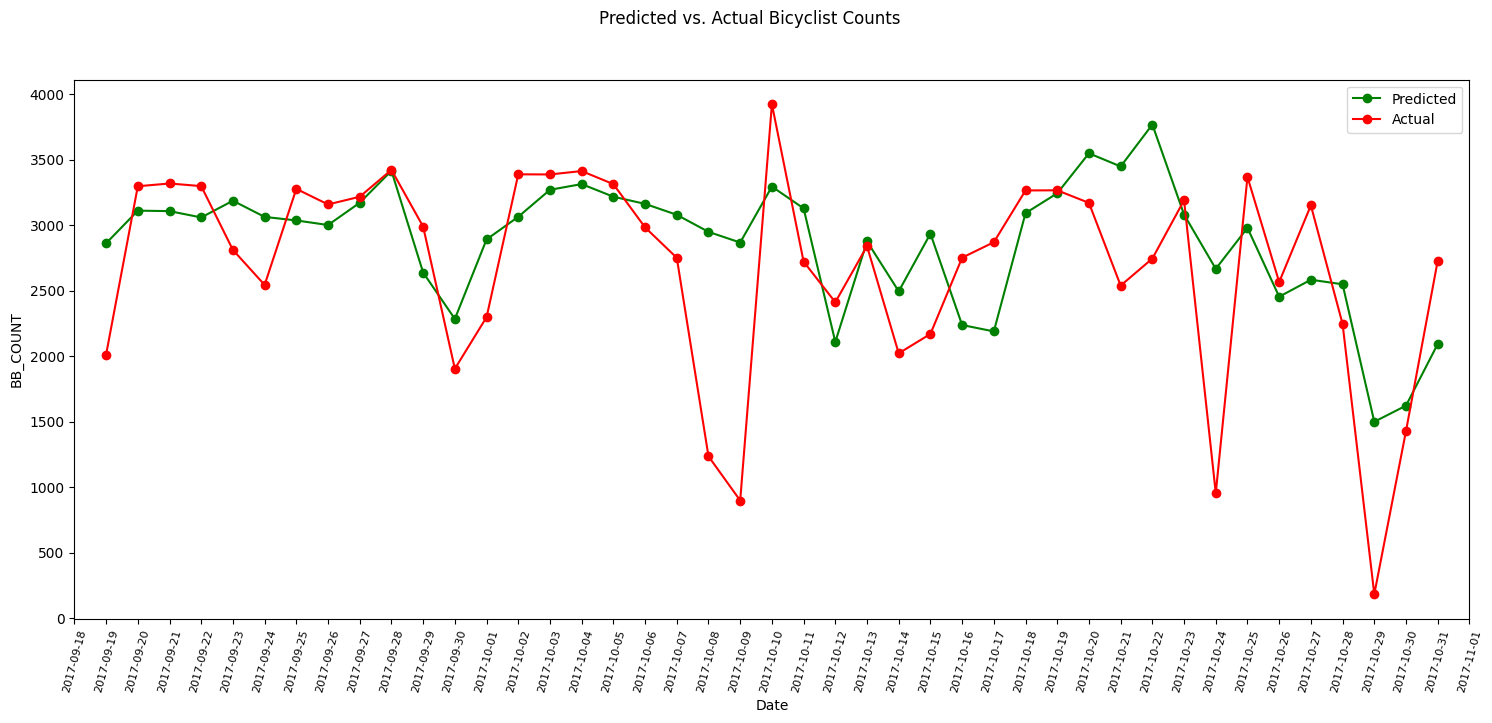

In [ ]:
# Plot the predicted counts versus the actual counts for the test data
actual_counts = y_test['BB_COUNT']
plt.figure(figsize=(18, 7))
plt.suptitle('Predicted vs. Actual Bicyclist Counts')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual')
plt.xlim([X_test.index.min() - pd.Timedelta(days=1), X_test.index.max() + pd.Timedelta(days=1)])
plt.xticks(rotation=75, fontsize=8)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Show every date
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.legend(handles=[predicted, actual])
plt.xlabel('Date')
plt.ylabel('BB_COUNT')
plt.show()

# Feature Engineering

In [160]:
import pandas as pd
from feature_engine.datetime import DatetimeFeatures
from feature_engine.timeseries.forecasting import LagFeatures, WindowFeatures
from feature_engine.creation import DecisionTreeFeatures
from feature_engine.selection import DropFeatures, DropDuplicateFeatures
from sklearn.impute import IterativeImputer
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn import set_config
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set configuration to output pandas DataFrames
set_config(transform_output="pandas")

In [138]:
# Periods list
periods_list = [1, 2, 3]
print(f"Lag periods: {periods_list}")

# Feature lists
X_feature_list = X_train.columns.tolist()
Xy_feature_list = X_train.columns.tolist() + ['BB_COUNT']
print(f"\nX variables: {X_feature_list}")
print(f"X and y variables: {Xy_feature_list}")

Lag periods: [1, 2, 3]

X variables: ['HIGH_T', 'LOW_T', 'PRECIP']
X and y variables: ['HIGH_T', 'LOW_T', 'PRECIP', 'BB_COUNT']


In [190]:
# Initialize feature engineering transformers
dt_feature_creator = DatetimeFeatures(variables='index', features_to_extract='all', missing_values='ignore')
lag_feature_creator = LagFeatures(variables=Xy_feature_list, periods=periods_list, missing_values='ignore')
window_feature_creator = WindowFeatures(variables=X_feature_list, window=3, functions=['mean', 'median', 'std', 'min', 'max', 'cov', 'skew', 'corr'], missing_values='ignore')
tree_feature_creator = DecisionTreeFeatures(variables=X_feature_list, features_to_combine=3, missing_values='ignore')
drop_features_1 = DropFeatures(features_to_drop=['BB_COUNT'])
drop_features_2 = DropFeatures(features_to_drop=['BB_COUNT'])
drop_features_3 = DropFeatures(features_to_drop=['BB_COUNT'])
drop_features_4 = DropFeatures(features_to_drop=['BB_COUNT'])

In [191]:
# Create lag features, followed by dropping the target variable
lag_and_drop_pipeline = Pipeline([
    ('lag_features', lag_feature_creator),
    ('lag_drop_target', drop_features_1)
])

# Drop target variable, followed by creating the datetime features
drop_and_dt_pipeline = Pipeline([
    ('dt_drop_target', drop_features_2),
    ('datetime', dt_feature_creator)
])

# Drop target variable, followed by creating the window features
drop_and_window_pipeline = Pipeline([
    ('window_drop_target', drop_features_3),
    ('window', window_feature_creator)
])

# Drop target variable, followed by creating the decision tree features
drop_and_tree_pipeline = Pipeline([
    ('tree_drop_target', drop_features_4),
    ('tree', tree_feature_creator)
])

In [192]:
# Combine all feature transformations with FeatureUnion
feature_union = FeatureUnion([
    ('lag_and_drop', lag_and_drop_pipeline),        # Create lag features and drop target
    ('drop_and_dt', drop_and_dt_pipeline),          # Drop target and create datetime features
    ('drop_and_window', drop_and_window_pipeline),  # Drop target and create window features
    ('drop_and_tree', drop_and_tree_pipeline)       # Drop target and create decision tree features
])

In [193]:
# Transformer to clean feature names
import pandas as pd
from sklearn.base import TransformerMixin


class CleanFeatureNames(TransformerMixin):
    """
    Transformer that cleans feature names by replacing problematic characters
    that are not allowed by certain models, such as XGBoost.

    Specifically, this transformer replaces '[' with '(' and ']' with ')'
    to avoid issues with feature names that contain these characters.

    Methods
    -------
    fit(X, y=None)
        No-op; returns self.

    transform(X)
        Replaces problematic characters in the DataFrame column names and
        returns the modified DataFrame.
    """

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Replace problematic characters in column names
        X.columns = X.columns.str.replace('[', '(', regex=False).str.replace(']', ')', regex=False)
        return X

In [223]:
# Transformer to inspect the DataFrame
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin


class DataFrameInspector(BaseEstimator, TransformerMixin):
    """
    A transformer that stores the DataFrame passed through the pipeline as an attribute.

    This transformer is useful for debugging and understanding the intermediate steps
    in a machine learning pipeline. It stores the DataFrame during the `transform`
    step, allowing inspection of the DataFrame after the pipeline has been fitted.

    Parameters
    ----------
    None

    Attributes
    ----------
    dataframe_ : pd.DataFrame
        Stores the DataFrame passed through the transformer during the `transform` step.

    Methods
    -------
    fit(X, y=None)
        No-op; returns self.

    transform(X)
        Stores the DataFrame and returns it unchanged.
    """

    def __init__(self):
        self.dataframe_ = None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input to DataFrameInspector must be a Pandas DataFrame.")

        # Save the DataFrame for later access
        self.dataframe_ = X.copy()
        return X

In [225]:
# Initialize the inspector
inspector = DataFrameInspector()

# Initialize the regressor
xgb_regressor = XGBRegressor()

# Create the full pipeline
full_pipeline = Pipeline(steps=[
    ('feature_union', feature_union),              # Combine all feature engineering steps
    ('drop_duplicates', DropDuplicateFeatures()),  # Drop duplicate features
    ('imputer', IterativeImputer()),               # Impute missing values
    ('clean_names', CleanFeatureNames()),          # Clean the feature names to be compatible with XGBoost
    ('inspector', inspector),                      # Inspect the DataFrame
    ('regressor', xgb_regressor)                   # Regressor
])

In [226]:
# Concatenate X_train and y_train
train_data = pd.concat([X_train, y_train], axis=1)

# Fit the pipeline on the concatenated training data
full_pipeline.fit(train_data, y_train)

Pipeline(steps=[('feature_union',
                 FeatureUnion(transformer_list=[('lag_and_drop',
                                                 Pipeline(steps=[('lag_features',
                                                                  LagFeatures(missing_values='ignore',
                                                                              periods=[1,
                                                                                       2,
                                                                                       3],
                                                                              variables=['HIGH_T',
                                                                                         'LOW_T',
                                                                                         'PRECIP',
                                                                                         'BB_COUNT'])),
                                                                 ('lag_drop_target',
                                                                  DropFeatures(features_to_drop=['BB_COUNT']))])),
                                                ('drop_and_dt',
                                                 Pipeline(steps=[('dt_drop_target',
                                                                  DropFeatures(featur...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [227]:
# Inspect the DataFrame passed to XGBoost
print("Shape of DataFrame passed to the regressor:")
print(inspector.dataframe_.shape)

print("\nColumns in the DataFrame:")
print(inspector.dataframe_.columns)

print("\nFirst few rows of the DataFrame:")
display(inspector.dataframe_.head())

Shape of DataFrame passed to the regressor:
(171, 61)

Columns in the DataFrame:
Index(['lag_and_drop__HIGH_T', 'lag_and_drop__LOW_T', 'lag_and_drop__PRECIP',
       'lag_and_drop__HIGH_T_lag_1', 'lag_and_drop__LOW_T_lag_1',
       'lag_and_drop__PRECIP_lag_1', 'lag_and_drop__BB_COUNT_lag_1',
       'lag_and_drop__HIGH_T_lag_2', 'lag_and_drop__LOW_T_lag_2',
       'lag_and_drop__PRECIP_lag_2', 'lag_and_drop__BB_COUNT_lag_2',
       'lag_and_drop__HIGH_T_lag_3', 'lag_and_drop__LOW_T_lag_3',
       'lag_and_drop__PRECIP_lag_3', 'lag_and_drop__BB_COUNT_lag_3',
       'drop_and_dt__month', 'drop_and_dt__quarter', 'drop_and_dt__semester',
       'drop_and_dt__year', 'drop_and_dt__week', 'drop_and_dt__day_of_week',
       'drop_and_dt__day_of_month', 'drop_and_dt__day_of_year',
       'drop_and_dt__weekend', 'drop_and_dt__month_start',
       'drop_and_dt__month_end', 'drop_and_dt__quarter_start',
       'drop_and_dt__quarter_end', 'drop_and_dt__year_start',
       'drop_and_dt__days_in_mont

,lag_and_drop__HIGH_T,lag_and_drop__LOW_T,lag_and_drop__PRECIP,lag_and_drop__HIGH_T_lag_1,lag_and_drop__LOW_T_lag_1,lag_and_drop__PRECIP_lag_1,lag_and_drop__BB_COUNT_lag_1,lag_and_drop__HIGH_T_lag_2,lag_and_drop__LOW_T_lag_2,lag_and_drop__PRECIP_lag_2,...,drop_and_window__PRECIP_window_3_cov,drop_and_window__PRECIP_window_3_skew,drop_and_window__PRECIP_window_3_corr,drop_and_tree__tree(HIGH_T),drop_and_tree__tree(LOW_T),drop_and_tree__tree(PRECIP),"drop_and_tree__tree(('HIGH_T', 'LOW_T'))","drop_and_tree__tree(('HIGH_T', 'PRECIP'))","drop_and_tree__tree(('LOW_T', 'PRECIP'))","drop_and_tree__tree(('HIGH_T', 'LOW_T', 'PRECIP'))"
Date,,,,,,,,,,,,,,,,,,,,,
2017-04-01,46.0,37.0,0.00,74.005933,62.178332,0.140355,2032.058044,75.038497,62.342026,0.140675,...,0.201083,0.606658,1.0,632.600000,2103.244898,3020.478992,914.000000,2544.205882,2615.096774,1380.750000
2017-04-02,62.1,41.0,0.00,46.000000,37.000000,0.000000,606.000000,80.884083,62.342202,0.128925,...,-0.040514,1.002224,1.0,2395.478261,2103.244898,3020.478992,2610.485714,2544.205882,2615.096774,1380.750000
2017-04-03,63.0,50.0,0.03,62.100000,41.000000,0.000000,2021.000000,46.000000,37.000000,0.000000,...,-0.118325,1.572306,1.0,2395.478261,2103.244898,2375.000000,2610.485714,2544.205882,1683.666667,2699.333333
2017-04-04,51.1,46.0,1.18,63.000000,50.000000,0.030000,2470.000000,62.100000,41.000000,0.000000,...,0.000300,1.732051,1.0,632.600000,2103.244898,1002.000000,445.000000,620.250000,491.800000,530.714286
2017-04-05,63.0,46.0,0.00,51.100000,46.000000,1.180000,723.000000,63.000000,50.000000,0.030000,...,0.452633,1.728177,1.0,2395.478261,2103.244898,3020.478992,2610.485714,2544.205882,2615.096774,2699.333333


In [228]:
import dill as pickle

# Save the pipeline
with open("FeatEngPipeline.pkl", "wb") as f:
    pickle.dump(full_pipeline, f)

# Load the pipeline
with open("FeatEngPipeline.pkl", "rb") as f:
    loaded_pipeline = pickle.load(f)

In [229]:
# Concatenate test data
test_data = pd.concat([X_test, y_test], axis=1)

# Make predictions using the best pipeline
predicted_counts = loaded_pipeline.predict(test_data)
predicted_counts = pd.DataFrame(predicted_counts, index=test_data.index, columns=['BB_COUNT'])

# Print out the predictions
print("First few predictions:")
display(predicted_counts.head())
print("\nLast few predictions:")
display(predicted_counts.tail())

First few predictions:


,BB_COUNT
Date,
2017-09-19,2749.991211
2017-09-20,3183.154297
2017-09-21,3179.068848
2017-09-22,3735.163818
2017-09-23,2921.428467



Last few predictions:


,BB_COUNT
Date,
2017-10-27,2915.181396
2017-10-28,2602.418945
2017-10-29,1683.914307
2017-10-30,1461.609985
2017-10-31,1724.589844


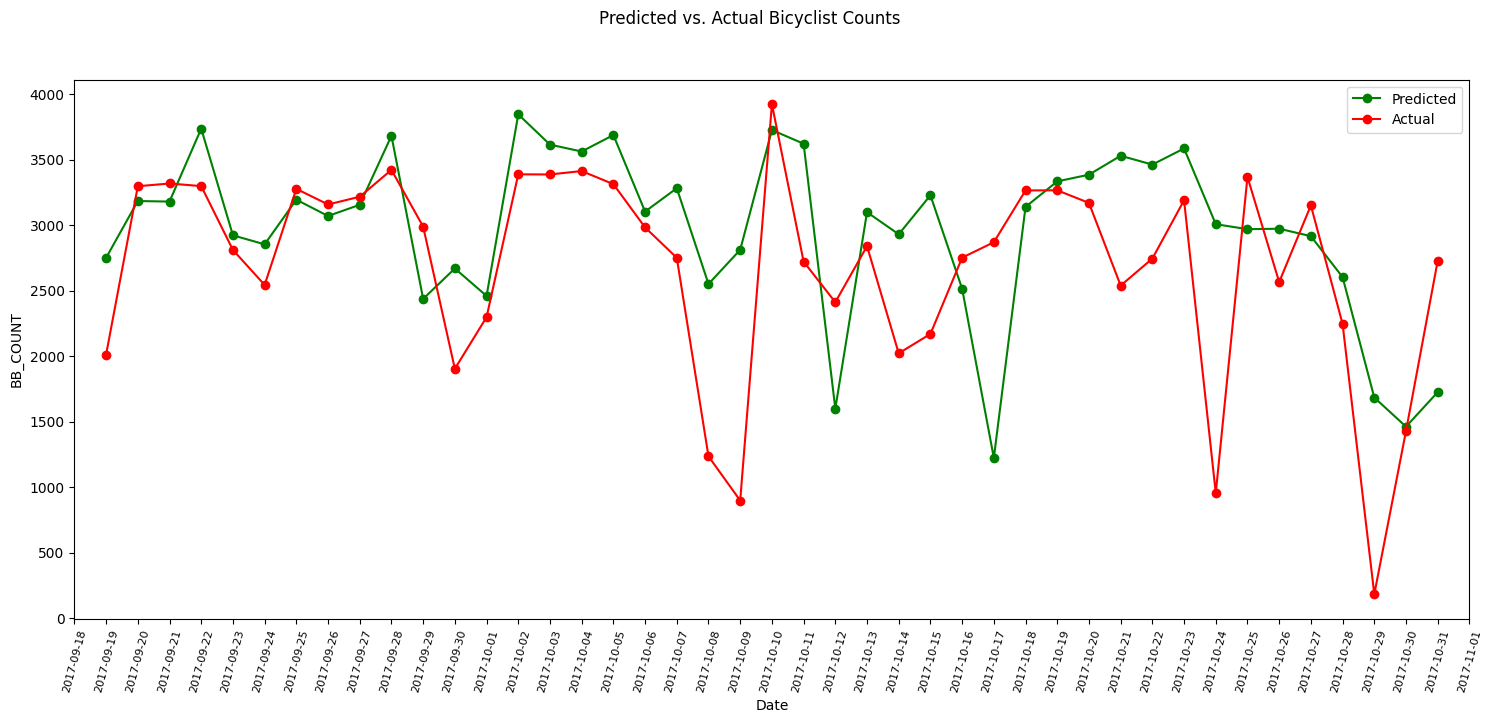

In [230]:
# Plot the predicted counts versus the actual counts for the test data
actual_counts = y_test['BB_COUNT']
plt.figure(figsize=(18, 7))
plt.suptitle('Predicted vs. Actual Bicyclist Counts')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual')
plt.xlim([X_test.index.min() - pd.Timedelta(days=1), X_test.index.max() + pd.Timedelta(days=1)])
plt.xticks(rotation=75, fontsize=8)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Show every date
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.legend(handles=[predicted, actual])
plt.xlabel('Date')
plt.ylabel('BB_COUNT')
plt.show()

In [233]:
# Predict on the test data
y_pred = loaded_pipeline.predict(test_data)

# Function to ensure input is a Pandas Series
def to_series(data, index=None):
    if isinstance(data, pd.DataFrame):
        return data.squeeze()  # Convert single-column DataFrame to Series
    elif isinstance(data, np.ndarray):
        return pd.Series(data, index=index)  # Convert NumPy array to Series with optional index
    elif isinstance(data, pd.Series):
        return data  # Already a Series
    else:
        raise ValueError("Input must be a Pandas DataFrame, Series, or NumPy array.")

# Function to compute MASE
def mase(y_true, y_pred, y_train):
    y_true = to_series(y_true)
    y_pred = to_series(y_pred, index=y_true.index)
    y_train = to_series(y_train)

    n = len(y_train)
    d = np.abs(np.diff(y_train)).sum() / (n - 1)
    errors = np.abs(y_true - y_pred)
    return errors.mean() / d

# Function to compute MAPE
def mape(y_true, y_pred):
    y_true = to_series(y_true)
    y_pred = to_series(y_pred, index=y_true.index)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to compute sMAPE
def smape(y_true, y_pred):
    y_true = to_series(y_true)
    y_pred = to_series(y_pred, index=y_true.index)

    return np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100

In [246]:
# Calculate performance metrics
mse_val = mean_squared_error(y_test, y_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_test, y_pred)
mase_val = mase(y_test, y_pred, y_train)
mape_val = mape(y_test, y_pred)
smape_val = smape(y_test, y_pred)

# Compile metrics into a dictionary
metrics_dict = {
    'MSE': mse_val,
    'RMSE': rmse_val,
    'MAE': mae_val,
    'MASE': mase_val,
    'MAPE': mape_val,
    'sMAPE': smape_val
}

# Convert dictionary to DataFrame
metrics_df = pd.DataFrame(metrics_dict, index=['Score']).T.round(3)

# Name index 'Metrics'
metrics_df.index.name = 'Metric'

# Display the DataFrame
display(metrics_df)

,Score
Metric,
MSE,557478.323
RMSE,746.645
MAE,544.762
MASE,0.681
MAPE,46.266
sMAPE,24.649


# Quantile Regression

In [247]:
from sklearn.metrics import mean_pinball_loss

# Define the quantiles for the prediction interval
quantiles = [0.1, 0.5, 0.9]

# Initialize a dictionary to store the models for each quantile
models = {}

# Loop through each quantile and train the model
for quantile in quantiles:
    # Copy the pipeline
    pipeline_quantile = Pipeline(steps=[
        ('feature_union', feature_union),
        ('drop_duplicates', DropDuplicateFeatures()),
        ('imputer', IterativeImputer()),
        ('clean_names', CleanFeatureNames()),
        ('inspector', inspector),
        ('regressor', XGBRegressor(
            objective="reg:quantileerror",
            quantile_alpha=quantile,
            n_estimators=100,
            learning_rate=0.1
        ))
    ])

    # Fit the pipeline
    pipeline_quantile.fit(train_data, y_train)

    # Store the trained model in the dictionary
    models[quantile] = pipeline_quantile

In [248]:
# Predict on the test data for each quantile
predictions = {}
for quantile in quantiles:
    predictions[quantile] = models[quantile].predict(test_data)

# Calculate the pinball loss for each quantile
pinball_losses = {}
for quantile in quantiles:
    pinball_loss = mean_pinball_loss(y_test, predictions[quantile], alpha=quantile)
    pinball_losses[quantile] = pinball_loss
    print(f"Pinball Loss at {quantile} quantile: {pinball_loss:.4f}")

Pinball Loss at 0.1 quantile: 212.1446
Pinball Loss at 0.5 quantile: 241.2325
Pinball Loss at 0.9 quantile: 89.0371


In [260]:
# Create pinball losses DataFrame
pinball_losses_df = pd.DataFrame.from_dict(pinball_losses, orient='index', columns=['Pinball Loss'])
pinball_losses_df.index.name = 'Quantile'
display(pinball_losses_df)

,Pinball Loss
Quantile,
0.1,212.144619
0.5,241.232466
0.9,89.037145


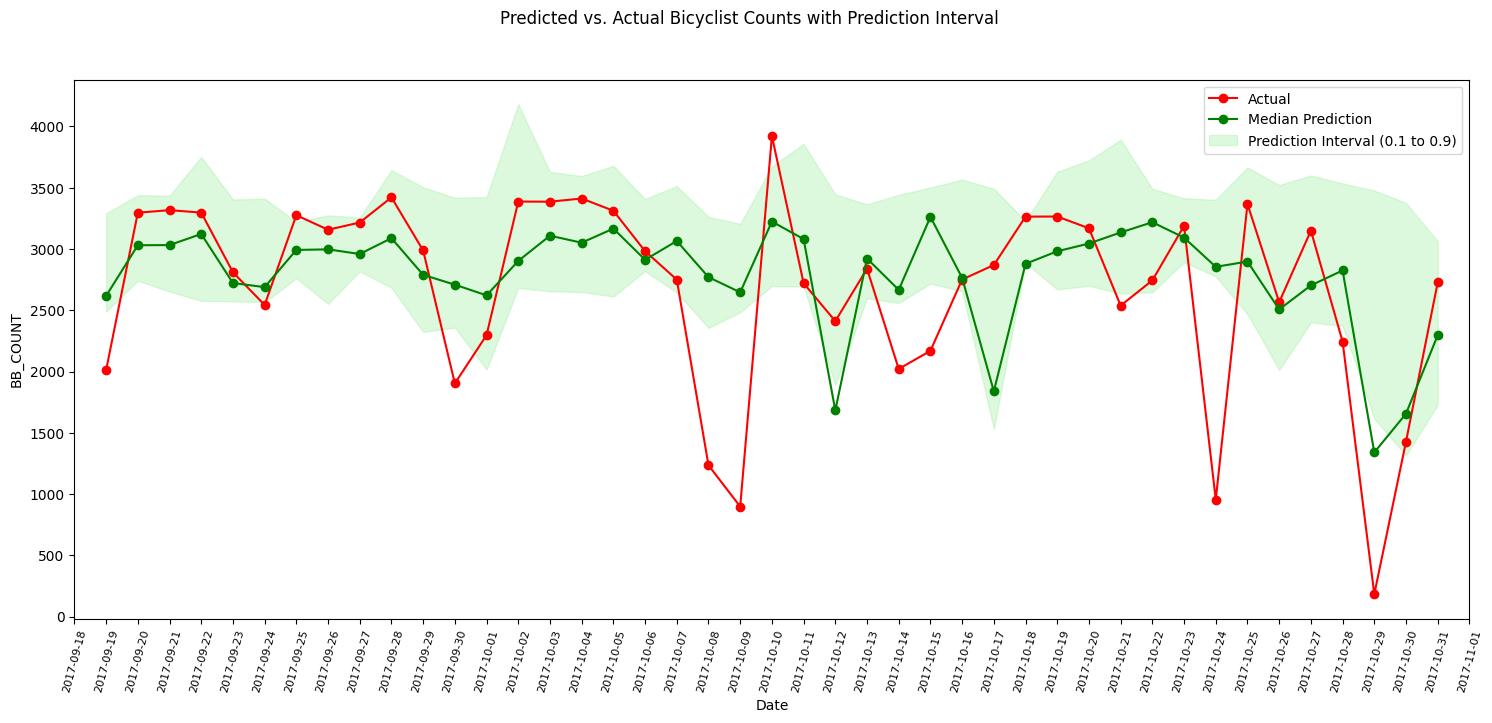

In [259]:
# Plot the predicted counts versus actual counts, with prediction interval
plt.figure(figsize=(18, 7))
plt.suptitle('Predicted vs. Actual Bicyclist Counts with Prediction Interval')
actual, = plt.plot(X_test.index, y_test['BB_COUNT'], 'ro-', label='Actual')
predicted_median, = plt.plot(X_test.index, predictions[0.5], 'go-', label='Median Prediction')
prediction_interval = plt.fill_between(X_test.index, predictions[0.1], predictions[0.9], color='lightgreen', alpha=0.3, label='Prediction Interval (0.1 to 0.9)')
plt.xlim([X_test.index.min() - pd.Timedelta(days=1), X_test.index.max() + pd.Timedelta(days=1)])
plt.xticks(rotation=75, fontsize=8)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xlabel('Date')
plt.ylabel('BB_COUNT')
plt.legend(handles=[actual, predicted_median, prediction_interval])
plt.show()

# Recursive Forecasting

In [267]:
# Function to perform recursive forecasting
def recursive_forecasting_pipeline(loaded_pipeline, train_data, forecast_horizon, window_type='expanding', window_size=None, initial_window=None, step_size=1):
    """
    Perform recursive forecasting using a given pipeline.

    Parameters:
    ----------
    loaded_pipeline : Pipeline
        The trained pipeline used for making predictions.

    train_data : DataFrame
        The initial training data containing all historical observations.

    forecast_horizon : int
        The number of steps ahead to forecast (i.e., the length of the test data).

    window_type : str, optional (default='expanding')
        The type of window to use for forecasting.
        Options are 'expanding' for an expanding window or 'sliding' for a sliding window.

    window_size : int, optional (default=None)
        The size of the sliding window. Used only if `window_type` is 'sliding'.

    initial_window : int, optional (default=None)
        The initial window size for the expanding window. Used only if `window_type` is 'expanding'.

    step_size : int, optional (default=1)
        The number of steps to expand the window after each prediction. Used only if `window_type` is 'expanding'.

    Returns:
    -------
    recursive_predictions : Series
        A Pandas Series containing the recursive predictions, indexed by the same index as the test data.
    """

    # Copy the training data to avoid modifying the original DataFrame
    train_data = train_data.copy()

    # If expanding window is chosen, initialize the expanding window
    if window_type == 'expanding' and initial_window:
        train_data = train_data.iloc[-initial_window:]  # Start with the initial window size

    # Initialize a list to store predictions
    recursive_predictions = []

    # Start forecasting loop
    for i in range(forecast_horizon):
        # Predict the next value using the pipeline
        y_pred = loaded_pipeline.predict(train_data)

        # Store the prediction
        recursive_predictions.append(y_pred[0])

        # Prepare the next input by appending the prediction to the training data
        next_input = train_data.iloc[[-1]].copy()  # Get the last row to modify
        next_input['BB_COUNT'] = y_pred[0]  # Replace the actual with the predicted value

        # Update the index to ensure uniqueness
        new_index = train_data.index[-1] + pd.Timedelta(days=1)
        next_input.index = [new_index]  # Set a new index that is unique

        # Append the new input to the training data
        train_data = pd.concat([train_data, next_input])

        # Handle sliding window
        if window_type == 'sliding' and window_size:
            if len(train_data) > window_size:
                train_data = train_data.iloc[-window_size:]  # Keep only the last `window_size` rows

        # Handle expanding window
        elif window_type == 'expanding' and initial_window:
            train_data = train_data.iloc[-(initial_window + i * step_size):]  # Expand window with step size

    # Convert predictions to a Series with an appropriate index
    recursive_predictions = pd.Series(recursive_predictions, index=test_data.index[:forecast_horizon], name='Predicted_BB_COUNT')

    return recursive_predictions

In [271]:
# Set the forecast horizon
forecast_horizon = len(test_data)

# For a sliding window approach
window_type = 'sliding'
window_size = 100

# For an expanding window approach
# window_type = 'expanding'
# initial_window = 100
# step_size = 3

In [272]:
# Perform recursive forecasting
recursive_predictions = recursive_forecasting_pipeline(
    loaded_pipeline,
    train_data,
    forecast_horizon,
    window_type=window_type,
    window_size=window_size,
    initial_window=None,
    step_size=None
)

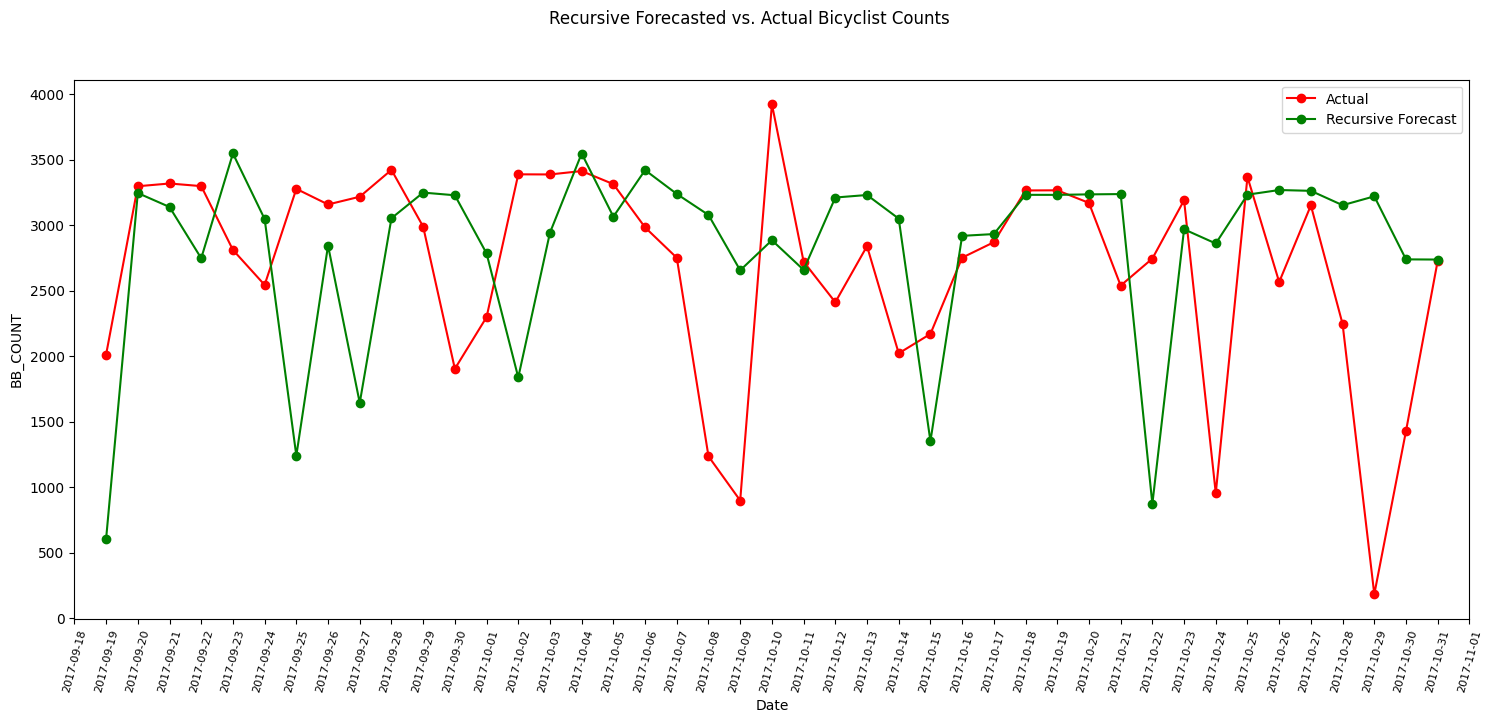

In [273]:
# Plot the recursive forecast along with actual values
plt.figure(figsize=(18, 7))
plt.suptitle('Recursive Forecasted vs. Actual Bicyclist Counts')
plt.plot(test_data.index, y_test['BB_COUNT'], 'ro-', label='Actual')
plt.plot(test_data.index, recursive_predictions, 'go-', label='Recursive Forecast')
plt.xlim([test_data.index.min() - pd.Timedelta(days=1), test_data.index.max() + pd.Timedelta(days=1)])
plt.xticks(rotation=75, fontsize=8)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xlabel('Date')
plt.ylabel('BB_COUNT')
plt.legend()
plt.show()